In [1]:
from droplet_growth import register, mic, poisson, fit

from droplet_growth import multiwell as mw
from glob import glob
import tifffile as tf
import matplotlib.pyplot as plt
import numpy as np
from functools import partial, reduce
from operator import add
import pandas as pd
import re
from multiprocessing import Pool
import os
import seaborn as sns

from scipy import ndimage as ndi
%load_ext autoreload
%autoreload 2

In [2]:
!pwd

/pasteur/sonic/homes/aaristov/nd2shrink


In [3]:
template16_path = "/pasteur/sonic/homes/aaristov/Anchor/Lena/Data/20210518_control/template_bin16_bf_mask.tif"
labels2 = tf.imread('/pasteur/sonic/homes/aaristov/Anchor/Lena/Data/labels_bin2.tif')
# mask1_path = "/pasteur/sonic/homes/aaristov/Anchor/Lena/Data/20210518_control/template_bin1_mask.tif"

template16, mask16 = tf.imread(template16_path)
# plt.imshow(template16, cmap='gray')
# plt.show()
# mask16 = mask16 > 0
# good_mask16 = mic.segment.filter_mask(mask16, size_lim=(15, 30),)
# plt.imshow(good_mask16, cmap='gray')
# plt.show()

# good_mask1 = tf.imread(mask1_path) > 0
# # good_mask1 = mic.segment.filter_mask(mask1, size_lim=(300, 600),)
# plt.imshow(good_mask1, cmap='gray')
# plt.title(good_mask1.shape)
# plt.show()

# print(mw.label(good_mask1)[1], 'regions')
# # tf.imwrite(mask1_path, good_mask1)

align = partial(register.align_stack, template16=template16, mask2=labels2, binnings=(2,16,2), plot=False)

In [5]:
paths = glob('/pasteur/sonic/homes/aaristov/Anchor/Lena/Data/20210628-MIC-0h/composites/*ng.tif')
paths

['/pasteur/sonic/homes/aaristov/Anchor/Lena/Data/20210628-MIC-0h/composites/10ng.tif',
 '/pasteur/sonic/homes/aaristov/Anchor/Lena/Data/20210628-MIC-0h/composites/15ng.tif',
 '/pasteur/sonic/homes/aaristov/Anchor/Lena/Data/20210628-MIC-0h/composites/00ng.tif',
 '/pasteur/sonic/homes/aaristov/Anchor/Lena/Data/20210628-MIC-0h/composites/02ng.tif',
 '/pasteur/sonic/homes/aaristov/Anchor/Lena/Data/20210628-MIC-0h/composites/08ng.tif',
 '/pasteur/sonic/homes/aaristov/Anchor/Lena/Data/20210628-MIC-0h/composites/06ng.tif',
 '/pasteur/sonic/homes/aaristov/Anchor/Lena/Data/20210628-MIC-0h/composites/12ng.tif',
 '/pasteur/sonic/homes/aaristov/Anchor/Lena/Data/20210628-MIC-0h/composites/04ng.tif']

In [10]:
def get_concentration(path, regex='(\d+)ng.tif'):
    try:
        ng = re.compile(regex).findall(path)[0]
        print (int(ng))
        return int(ng)
    except IndexError:
        print('concentration not found')
        
def align_n_count_mic(path, regex='(\d+)ng.tif', fun=align, n_max=10):
    # get concentration
    c = get_concentration(path, regex=regex)
    # align
    if not os.path.exists(apath := path.replace('.tif', '.aligned.tif')):
        _, fluo_aligned, mask_aligned = align(path)
    else:
        print(f'{c} ng already aligned')
        _, fluo_aligned, mask_aligned = tf.imread(apath)
    # count
    counts = mic.get_cell_numbers(
        fluo_aligned, 
        mask_aligned, 
        threshold_abs=2,
        plot=False,
        meta={'ng': c}
    )
    poisson.fit(counts.query(f'n_cells < {n_max}').n_cells, title=f'{c} ng')
    # return table
    counts.to_csv(path.replace('.tif', '-counts.csv'))
    return counts
    

In [7]:
list(map(get_concentration, paths))

10
15
0
2
8
6
12
4


[10, 15, 0, 2, 8, 6, 12, 4]

21510068124







12 ng already aligned15 ng already aligned0 ng already aligned8 ng already aligned2 ng already aligned4 ng already aligned10 ng already aligned6 ng already aligned









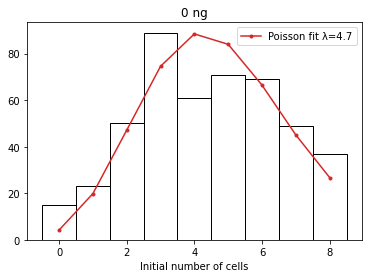

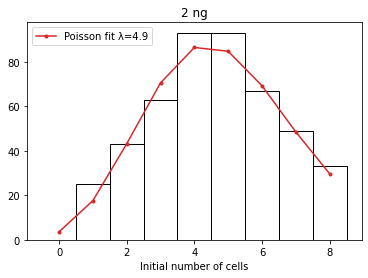

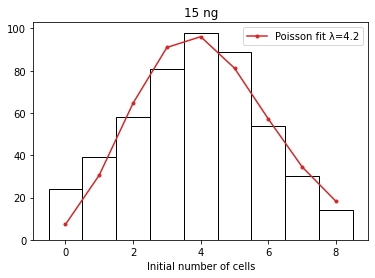

In [12]:
p = Pool(8)

In [13]:
counts = p.map(align_n_count_mic, paths)

In [14]:
p.close()

In [44]:
for p, c in zip(paths, counts):
    c.to_csv(p.replace('.tif', '-counts.csv'))

In [4]:
counts = pd.concat([pd.read_csv(a, index_col=0) for a in glob('/pasteur/sonic/homes/aaristov/Anchor/Lena/Data/20210628-MIC-0h/composites/*ng-counts.csv')], ignore_index=True)

In [5]:
counts

label            x             y  n_cells  ng
0         1   663.811609    416.729352       14   2
1         2   664.953437    949.176531        1   2
2         3   665.027521   1476.030946        3   2
3         4   661.544611  16297.639109        3   2
4         5   660.900634  16826.135524        1   2
...     ...          ...           ...      ...  ..
4003    497  5962.000000   4646.000000        6   4
4004    498  5961.847513   5177.567060        9   4
4005    499  5961.295918   5706.724968        2   4
4006    500  5961.408642   6237.083846       10   4
4007    501  5961.382560   6765.710278        5   4

[4008 rows x 5 columns]

# Align 24h

In [6]:
paths24 = glob('/pasteur/sonic/homes/aaristov/Anchor/Lena/Data/20210629-MIC-24h/composites/*ng-24h.tif')
paths24

['/pasteur/sonic/homes/aaristov/Anchor/Lena/Data/20210629-MIC-24h/composites/06ng-24h.tif',
 '/pasteur/sonic/homes/aaristov/Anchor/Lena/Data/20210629-MIC-24h/composites/10ng-24h.tif',
 '/pasteur/sonic/homes/aaristov/Anchor/Lena/Data/20210629-MIC-24h/composites/02ng-24h.tif',
 '/pasteur/sonic/homes/aaristov/Anchor/Lena/Data/20210629-MIC-24h/composites/12ng-24h.tif',
 '/pasteur/sonic/homes/aaristov/Anchor/Lena/Data/20210629-MIC-24h/composites/04ng-24h.tif',
 '/pasteur/sonic/homes/aaristov/Anchor/Lena/Data/20210629-MIC-24h/composites/00ng-24h.tif',
 '/pasteur/sonic/homes/aaristov/Anchor/Lena/Data/20210629-MIC-24h/composites/08ng-24h.tif',
 '/pasteur/sonic/homes/aaristov/Anchor/Lena/Data/20210629-MIC-24h/composites/15ng-24h.tif']

In [ ]:
p = Pool(8)
aligned24 = p.map(align, paths24)

/pasteur/sonic/homes/aaristov/Anchor/Lena/Data/20210629-MIC-24h/composites/06ng-24h.tif (2, 7019, 22259)
/pasteur/sonic/homes/aaristov/Anchor/Lena/Data/20210629-MIC-24h/composites/10ng-24h.tif (2, 7019, 22259)
/pasteur/sonic/homes/aaristov/Anchor/Lena/Data/20210629-MIC-24h/composites/02ng-24h.tif (2, 7019, 22259)
/pasteur/sonic/homes/aaristov/Anchor/Lena/Data/20210629-MIC-24h/composites/12ng-24h.tif (2, 7019, 22259)
/pasteur/sonic/homes/aaristov/Anchor/Lena/Data/20210629-MIC-24h/composites/04ng-24h.tif (2, 7019, 22259)
/pasteur/sonic/homes/aaristov/Anchor/Lena/Data/20210629-MIC-24h/composites/00ng-24h.tif (2, 7019, 22259)
/pasteur/sonic/homes/aaristov/Anchor/Lena/Data/20210629-MIC-24h/composites/08ng-24h.tif (2, 7019, 22259)
/pasteur/sonic/homes/aaristov/Anchor/Lena/Data/20210629-MIC-24h/composites/15ng-24h.tif (2, 7019, 22259)
{'tvec': array([ 48.11256235, 294.54095361]), 'success': 0.024778496181194327, 'angle': -0.011923371562090779, 'scale': 0.9977391360234054, 'Dscale': 0.00047568

In [ ]:
p.close()

In [5]:
alighend_paths24 = glob('/pasteur/sonic/homes/aaristov/Anchor/Lena/Data/20210623-MIC-24h-5x/Composites/*ng-Composite.aligned.tif')
alighend_paths24

['/pasteur/sonic/homes/aaristov/Anchor/Lena/Data/20210623-MIC-24h-5x/Composites/04ng-Composite.aligned.tif',
 '/pasteur/sonic/homes/aaristov/Anchor/Lena/Data/20210623-MIC-24h-5x/Composites/02ng-Composite.aligned.tif',
 '/pasteur/sonic/homes/aaristov/Anchor/Lena/Data/20210623-MIC-24h-5x/Composites/00ng-Composite.aligned.tif',
 '/pasteur/sonic/homes/aaristov/Anchor/Lena/Data/20210623-MIC-24h-5x/Composites/06ng-Composite.aligned.tif',
 '/pasteur/sonic/homes/aaristov/Anchor/Lena/Data/20210623-MIC-24h-5x/Composites/10ng-Composite.aligned.tif',
 '/pasteur/sonic/homes/aaristov/Anchor/Lena/Data/20210623-MIC-24h-5x/Composites/08ng-Composite.aligned.tif']

In [40]:
get_intensities = partial(mic.get_intensities, save_suffix='intensities')

In [41]:
p = Pool(6)
intensities = p.map(get_intensities, alighend_paths24)

TiffPage 0: TypeError: read_bytes() missing 3 required positional arguments: 'dtype', 'count', and 'offsetsize'
TiffPage 0: TypeError: read_bytes() missing 3 required positional arguments: 'dtype', 'count', and 'offsetsize'
TiffPage 0: TypeError: read_bytes() missing 3 required positional arguments: 'dtype', 'count', and 'offsetsize'


/pasteur/sonic/homes/aaristov/Anchor/Lena/Data/20210623-MIC-24h-5x/Composites/04ng-Composite.aligned.tif
(6544, 20896, 3)
(6544, 20896)
/pasteur/sonic/homes/aaristov/Anchor/Lena/Data/20210623-MIC-24h-5x/Composites/08ng-Composite.aligned.tif
(6544, 20896, 3)
(6544, 20896)
/pasteur/sonic/homes/aaristov/Anchor/Lena/Data/20210623-MIC-24h-5x/Composites/02ng-Composite.aligned.tif
(6544, 20896, 3)
(6544, 20896)


TiffPage 0: TypeError: read_bytes() missing 3 required positional arguments: 'dtype', 'count', and 'offsetsize'


/pasteur/sonic/homes/aaristov/Anchor/Lena/Data/20210623-MIC-24h-5x/Composites/10ng-Composite.aligned.tif
(6544, 20896, 3)
(6544, 20896)
/pasteur/sonic/homes/aaristov/Anchor/Lena/Data/20210623-MIC-24h-5x/Composites/06ng-Composite.aligned.tif
(6544, 20896, 3)
(6544, 20896)
/pasteur/sonic/homes/aaristov/Anchor/Lena/Data/20210623-MIC-24h-5x/Composites/00ng-Composite.aligned.tif
(6544, 20896, 3)
(6544, 20896)
08
04
02
06
10
00
Saved /pasteur/sonic/homes/aaristov/Anchor/Lena/Data/20210623-MIC-24h-5x/Composites/04ng-Composite.aligned.intensities.tif
Saved /pasteur/sonic/homes/aaristov/Anchor/Lena/Data/20210623-MIC-24h-5x/Composites/08ng-Composite.aligned.intensities.tif
Saved /pasteur/sonic/homes/aaristov/Anchor/Lena/Data/20210623-MIC-24h-5x/Composites/10ng-Composite.aligned.intensities.tif
Saved /pasteur/sonic/homes/aaristov/Anchor/Lena/Data/20210623-MIC-24h-5x/Composites/06ng-Composite.aligned.intensities.tif
Saved /pasteur/sonic/homes/aaristov/Anchor/Lena/Data/20210623-MIC-24h-5x/Composite

In [7]:
p.close()

In [43]:
intensities = pd.concat(intensities)
intensities

label  mean_intensity  max_intensity  ng
0        1      413.576233            433   4
1        2      456.397614           2683   4
2        3      479.628113           3199   4
3        4      440.929779           1476   4
4        5      473.636322           2152   4
..     ...             ...            ...  ..
496    497      425.255371           2013   8
497    498      480.483856           2708   8
498    499      413.602020            441   8
499    500      415.317993           1704   8
500    501      459.138947           3854   8

[3006 rows x 4 columns]

In [46]:
i=1
intensities.query('ng == 0').query(f'label == {i}').mean_intensity

0    459.714783
Name: mean_intensity, dtype: float64

In [47]:
i=1
int(intensities.query('ng == 0').query(f'label == {i}').mean_intensity)

459

In [51]:
intensities = intensities.sort_values(['ng', 'label'], ignore_index=True)
# feb18_counts

counts = counts.sort_values(['ng', 'label'], ignore_index=True)
# feb_18_intensities

assert((counts.loc[:, ['ng', 'label']] == intensities.loc[:, ['ng', 'label']]).all().all())

table = pd.concat((intensities, counts.loc[:, ['n_cells']]), axis=1)
table

label  mean_intensity  max_intensity  ng  final_state  n_cells
0         1      459.714783           1265   0         True        2
1         2      505.158112           4063   0         True        0
2         3      413.960510            447   0        False        2
3         4      413.739563            443   0        False        0
4         5      510.123810           3818   0         True        1
...     ...             ...            ...  ..          ...      ...
3001    497      424.489807           1619  10        False        0
3002    498      415.718292           1507  10        False        0
3003    499      414.304016            793  10        False        3
3004    500      414.877441           1355  10        False        0
3005    501      495.099854           4211  10         True        1

[3006 rows x 6 columns]

In [52]:
table.loc[:, 'final_state'] = table.mean_intensity > 429

In [24]:
fig, ax = plt.subplots(dpi=300)
sns.swarmplot(ax=ax, data=intensities, x='ng', y='mean_intensity', size=1)

/opt/conda/lib/python3.9/site-packages/seaborn/categorical.py:1296: UserWarning: 6.8% of the points cannot be placed; you may want to decrease the size of the markers or use stripplot.
  warnings.warn(msg, UserWarning)
/opt/conda/lib/python3.9/site-packages/seaborn/categorical.py:1296: UserWarning: 9.0% of the points cannot be placed; you may want to decrease the size of the markers or use stripplot.
  warnings.warn(msg, UserWarning)
/opt/conda/lib/python3.9/site-packages/seaborn/categorical.py:1296: UserWarning: 17.2% of the points cannot be placed; you may want to decrease the size of the markers or use stripplot.
  warnings.warn(msg, UserWarning)
/opt/conda/lib/python3.9/site-packages/seaborn/categorical.py:1296: UserWarning: 39.7% of the points cannot be placed; you may want to decrease the size of the markers or use stripplot.
  warnings.warn(msg, UserWarning)
/opt/conda/lib/python3.9/site-packages/seaborn/categorical.py:1296: UserWarning: 49.3% of the points cannot be placed; you

<AxesSubplot:xlabel='ng', ylabel='mean_intensity'>

/opt/conda/lib/python3.9/site-packages/seaborn/categorical.py:1296: UserWarning: 18.1% of the points cannot be placed; you may want to decrease the size of the markers or use stripplot.
  warnings.warn(msg, UserWarning)
/opt/conda/lib/python3.9/site-packages/seaborn/categorical.py:1296: UserWarning: 7.0% of the points cannot be placed; you may want to decrease the size of the markers or use stripplot.
  warnings.warn(msg, UserWarning)
/opt/conda/lib/python3.9/site-packages/seaborn/categorical.py:1296: UserWarning: 13.7% of the points cannot be placed; you may want to decrease the size of the markers or use stripplot.
  warnings.warn(msg, UserWarning)
/opt/conda/lib/python3.9/site-packages/seaborn/categorical.py:1296: UserWarning: 14.6% of the points cannot be placed; you may want to decrease the size of the markers or use stripplot.
  warnings.warn(msg, UserWarning)
/opt/conda/lib/python3.9/site-packages/seaborn/categorical.py:1296: UserWarning: 41.1% of the points cannot be placed; yo

<AxesSubplot:xlabel='ng', ylabel='mean_intensity'>

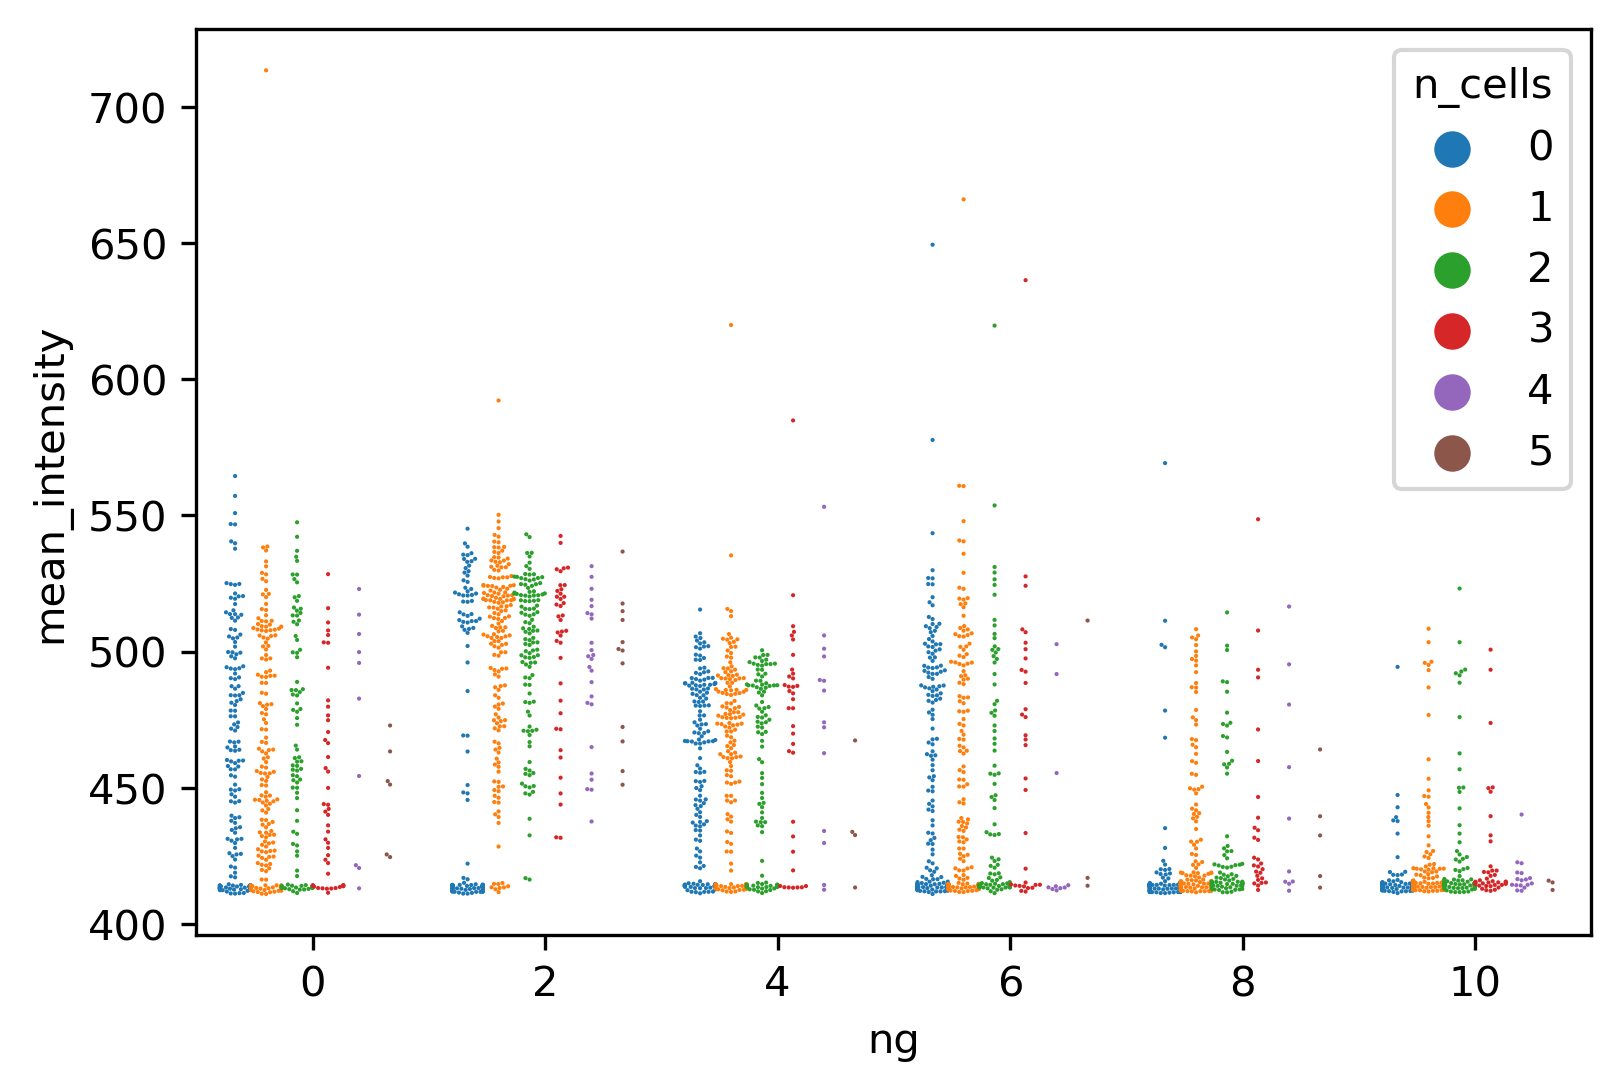

In [55]:
fig, ax = plt.subplots(dpi=300)
sns.swarmplot(ax=ax, data=table.query('n_cells < 6'), x='ng', y='mean_intensity', hue='n_cells', dodge=True, size=1)

<AxesSubplot:xlabel='ng', ylabel='final_state'>

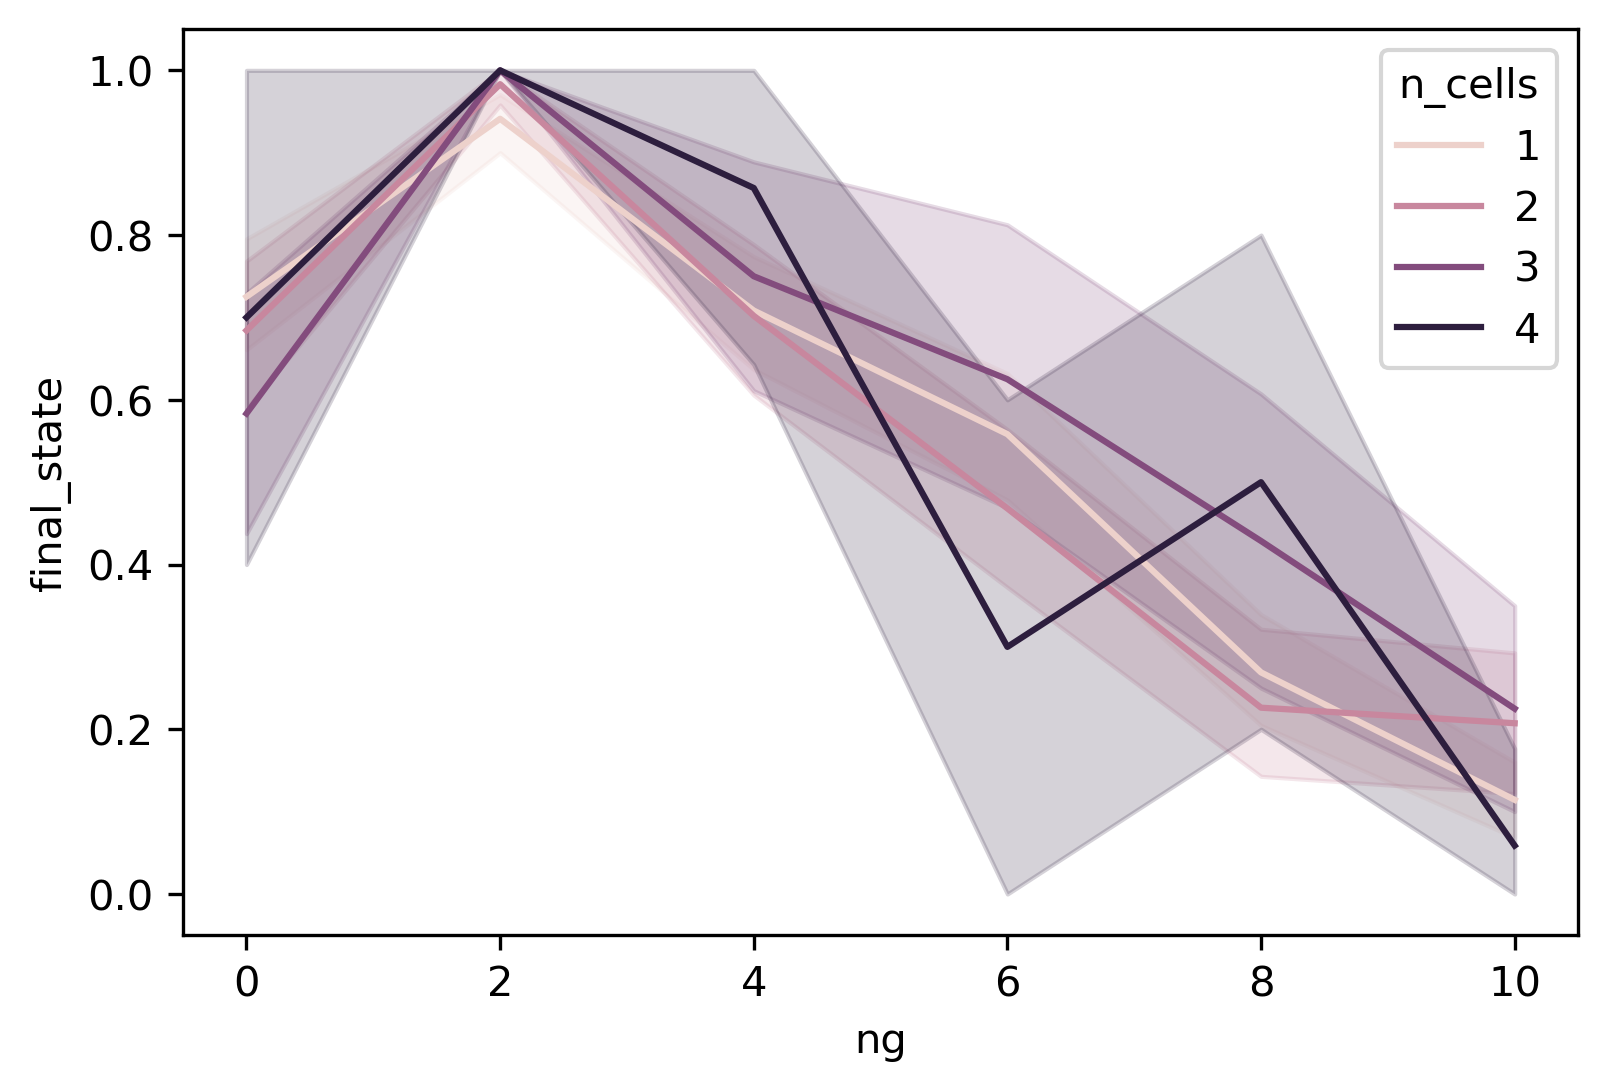

In [66]:
fig, ax = plt.subplots(dpi=300)
sns.lineplot(ax=ax, data=table.query('0 < n_cells < 5'), x='ng', y='final_state', hue='n_cells')

In [61]:
fig, ax = plt.subplots(dpi=300)
sns.lineplot(ax=ax, data=table.query('0 < n_cells < 4'), x='n_cells', y='final_state', hue='ng')

<AxesSubplot:xlabel='n_cells', ylabel='final_state'>

In [31]:
isorted = intensities.query('ng == 0').sort_values('mean_intensity', ignore_index=True)
thr = isorted.loc[117].mean_intensity
thr

416.23974609375

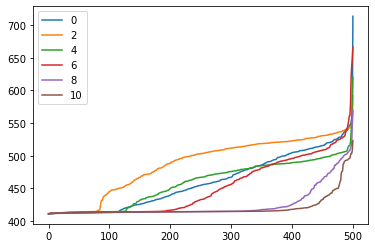

In [36]:
[intensities.query(f'ng == {c}').sort_values('mean_intensity', ignore_index=True).mean_intensity.plot(label=c) for c in range(0, 12,2)]
# plt.ylim(400, 450)
plt.legend()

array([[<AxesSubplot:title={'center':'mean_intensity'}>]], dtype=object)

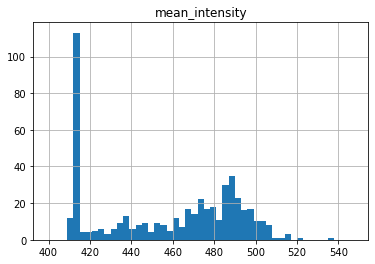

In [16]:
intensities[0].hist('mean_intensity', bins=np.arange(400,550, 3))